In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
from torch import optim
import syndata
import align
import mgplvm
from mgplvm import kernels, rdist
from mgplvm.manifolds import Torus
from mgplvm.models import Core
from mgplvm.training import train
plt.rcParams.update({'font.size': 22})

#import syndata.grid_data

In [8]:
torch.set_default_dtype(torch.float64)
device = mgplvm.utils.get_device("cuda")  # get_device("cpu")

data = pickle.load(open('grid_data.pickled'))
Y = data['Y']
Y = Y[:int(Y.shape[0]/3), :] #start with a single module
Y = Y+np.random.normal(0, 1, size = Y.shape)*np.mean(Y)/2 #add some noise

n, m = Y.shape
Y = np.expand_dims(Y, 2)

d = 2  # dims of latent space
n_z = 15  # number of inducing points


sig0 = 1.5

gen.set_param('l', l)
# specify manifold, kernel and rdist
manif = Torus(m, d)
ref_dist = mgplvm.rdist.MVN(m, d, sigma=sig0)
# initialize signal variance
alpha = np.mean(np.std(Y, axis=1), axis=1)
kernel = kernels.QuadExp(n, manif.distance, alpha=alpha)
# generate model
sigma = np.mean(np.std(Y, axis=1), axis=1)  # initialize noise
mod = Core(manif, n, m, n_z, kernel, ref_dist, sigma=sigma).to(device)

mean activity: 0.30928958556140584


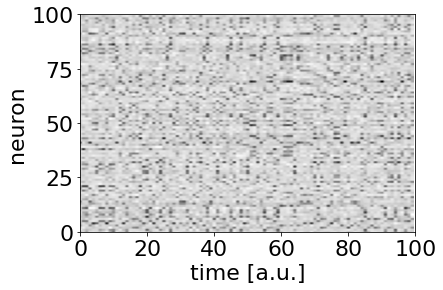

In [12]:
plt.figure()
Yplot = Y[:, :, 0]
plt.imshow(Yplot, cmap='Greys', aspect='auto')
plt.xlabel("time [a.u.]")
plt.ylabel("neuron")
plt.xlim(0,100)
plt.ylim(0,n)
plt.show()
plt.close()

In [10]:
# train model
trained_mod = train(Y,
                    mod,
                    device,
                    optimizer=optim.Adam,
                    outdir='none',
                    max_steps=1000,
                    burnin='default',
                    n_b=64,
                    lrate=5E-2,
                    print_every=50)

data = torch.tensor(Y, dtype=torch.get_default_dtype()).to(device)
mod = mod.to(device)
mulearn = mod.manif.prms.data.cpu()
mutrue = gen.gs[0]
plearn = mod.manif.distance(mulearn.T, mulearn.T).numpy()
ptrue = gen.manifold.manifs[0].distance(mutrue, mutrue)
ptrue, plearn = [p.flatten() for p in [ptrue, plearn]]

1000 100.0
iter  300 | elbo 0.3353 | kl 0.0370 | loss -0.3001 | |mu| 1.4634 | alpha_sqr 0.1853 | ell 0.7047 | sig 0.0363
done!


final importance weighted log likelihood: 0.3004


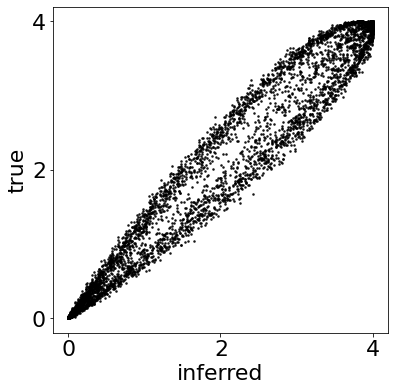

In [13]:
print('final importance weighted log likelihood: %.4f' % mod.calc_LL(data, 128).item())
plt.figure(figsize=(6, 6))
plt.plot(plearn, ptrue, "ko", markersize=1.5, alpha=0.5)
plt.xlabel("inferred")
plt.ylabel("true")
plt.xticks((0, 2, 4), ("$0$", "$2$", "$4$"))
plt.yticks((0, 2, 4), ("$0$", "$2$", "$4$"))
plt.show()
plt.close()

In [14]:
#align model to ground truth
mod = align.align_torus(mod, gen.gs[0])

# %% compute mse
query = mod.manif.mu.detach()
fmean, fstd = mod.predict(data, query, niter=100)
var = np.mean(np.var(Y, axis=1))
MSE = np.mean(((fmean - data)**2).cpu().numpy())
print('MSE:', MSE, 'var:', var)

coordinate system: [[-1]] 0 loss: 1.8885996192056844
coordinate system: [[-1]] 1 loss: 1.888599619194834
coordinate system: [[-1]] 2 loss: 2.0111144463313564
coordinate system: [[-1]] 3 loss: 1.8885996191948342
coordinate system: [[-1]] 4 loss: 1.8885996191954777
coordinate system: [[1]] 0 loss: 0.022472212694652053
coordinate system: [[1]] 1 loss: 0.022472212708239327
coordinate system: [[1]] 2 loss: 0.022472212675460436
coordinate system: [[1]] 3 loss: 0.022472212689643802
coordinate system: [[1]] 4 loss: 0.022472212722808162
MSE: 0.01884974972466499 var: 0.1096230806159981


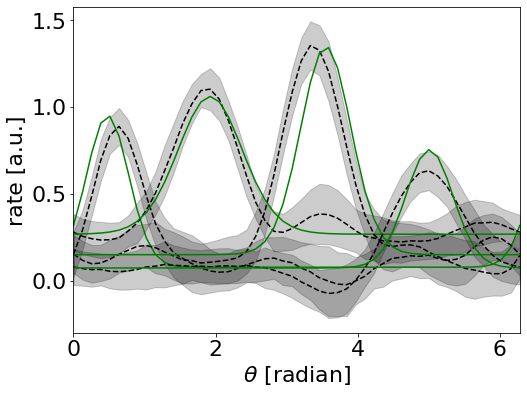

In [15]:
#%% consider 'tuning curves'
query = torch.tensor(np.linspace(0, 2 * np.pi, 50),
                     dtype=torch.get_default_dtype(),
                     device=device)

fmean, fstd = mod.predict(data, query, niter=100)
inds = [np.argmin((gen.gprefs[0] - val)**2) for val in 0.5 + np.arange(4) * 1.5]
plt.figure(figsize=(8, 6))

for i in inds:
    xs, m, std = [arr.cpu().numpy() for arr in [query, fmean, fstd]]
    m, std = [arr[i, :, 0] for arr in [m, std]]
    plt.plot(xs, m, "k--")
    plt.fill_between(xs, m - 2 * std, m + 2 * std, color='k', alpha=0.2)
    true_y = gen.gen_data(gs_in=[xs.reshape(-1, 1)], sigma=np.zeros((mod.n, 1)))
    plt.plot(xs, true_y[i, :, 0], 'g-')

plt.xlabel(r"$\theta$ [radian]")
plt.ylabel(r"rate [a.u.]")
plt.xlim(0, 2 * np.pi)
plt.show()
plt.close()